In [12]:
import galprime as gp

from galprime.plotting import pyplot_style, lavender_cmap
cmap = lavender_cmap()
pyplot_style()

import numpy as np

from scipy.signal import convolve2d

from astropy.table import Table
from astropy.visualization import ZScaleInterval

from matplotlib import pyplot as plt

config = gp.read_config_file("../notebooks/myconfig.gprime")

import warnings
warnings.filterwarnings("ignore")

In [13]:
config["EXTRACTION"]["LINEAR"] = True
config["EXTRACTION"]["STEP"] = 2
print(config["EXTRACTION"])

{'LINEAR': True, 'STEP': 2, 'NITER': '100', 'MAXIT': 100, 'FIX_CENTER': False, 'MAXRIT': 50, 'MINSMA': 1, 'CONVER': 0.05, 'INTEGRMODE': 'bilinear'}


In [14]:
backgrounds = gp.Cutouts.from_file(f'{config["FILE_DIR"]}{config["FILES"]["BACKGROUNDS"]}')
psfs = gp.Cutouts.from_file(f'{config["FILE_DIR"]}{config["FILES"]["PSFS"]}')

bg = backgrounds.cutouts[3][:251, :251]
vmin, vmax = ZScaleInterval().get_limits(bg)

In [23]:
mag = 21
reff = 10

sersicN1 = gp.SingleSersicModel()
# .generate(params={})
sersicN1 = gp.SingleSersicModel().generate(params={"MAG": mag, "REFF": 10, "N": 1, "PA": np.pi/4, "SHAPE":251})[0]
sersicN4, sersicN4params = gp.SingleSersicModel().generate(params={"MAG": mag, "REFF": 10, "N": 4, "PA": np.pi/4, "SHAPE":251})

bulgedisk = gp.BulgeDiskSersicModel()
print(bulgedisk.defaults)
bulgedisk = gp.BulgeDiskSersicModel().generate(params={"MAG": mag, "REFF_DISK": 10, "REFF_BULGE": 2,
                                                       "FBULGE": 0.2,
                                                       "N": 4, "PA": np.pi/4, "SHAPE":251})[0]

{'MAG': 16, 'FBULGE': 0.5, 'REFF_BULGE': 1, 'N_BULGE': 4, 'REFF_DISK': 1, 'ELLIP_DISK': 0.2, 'ELLIP_BULGE': 0.2}


In [25]:

def process_model(model):
    mod = model
    mod = convolve2d(mod, psfs.cutouts[10], mode="same")
    bgadded = mod + bg
    bgadded_masked = np.copy(bgadded)
    sourcemask = gp.gen_mask(bgadded, config)[0]
    bgadded_masked[sourcemask] = np.nan

    bg_sm, bg_mod = gp.estimate_background_2D(bgadded, config)
    bgsub = bgadded - bg_mod.background
    
    sourcemask = gp.gen_mask(bgsub, config)[0]
    bgsub[sourcemask] = np.nan

    mod_prof = gp.isophote_fitting(mod, config)
    bgadded_prof = gp.isophote_fitting(bgadded_masked, config)
    bgsub_prof = gp.isophote_fitting(bgsub, config)

    return [mod, bgadded_masked, bgsub, mod_prof["ISOLIST"], bgadded_prof["ISOLIST"], bgsub_prof["ISOLIST"]]

output_n1 = process_model(sersicN1)
output_n4 = process_model(sersicN4)
output_bd = process_model(bulgedisk)


In [26]:
def overplot_isophotes(ax, isolist, rs=np.arange(0, 100, 5), **kwargs):
    for i in rs:
        iso = isolist.get_closest(i)
        ax.scatter(iso.sampled_coordinates()[0], iso.sampled_coordinates()[1], 
                color=kwargs.get("color", "white"), alpha=kwargs.get("alpha", 1),
                s=kwargs.get("s", 1))

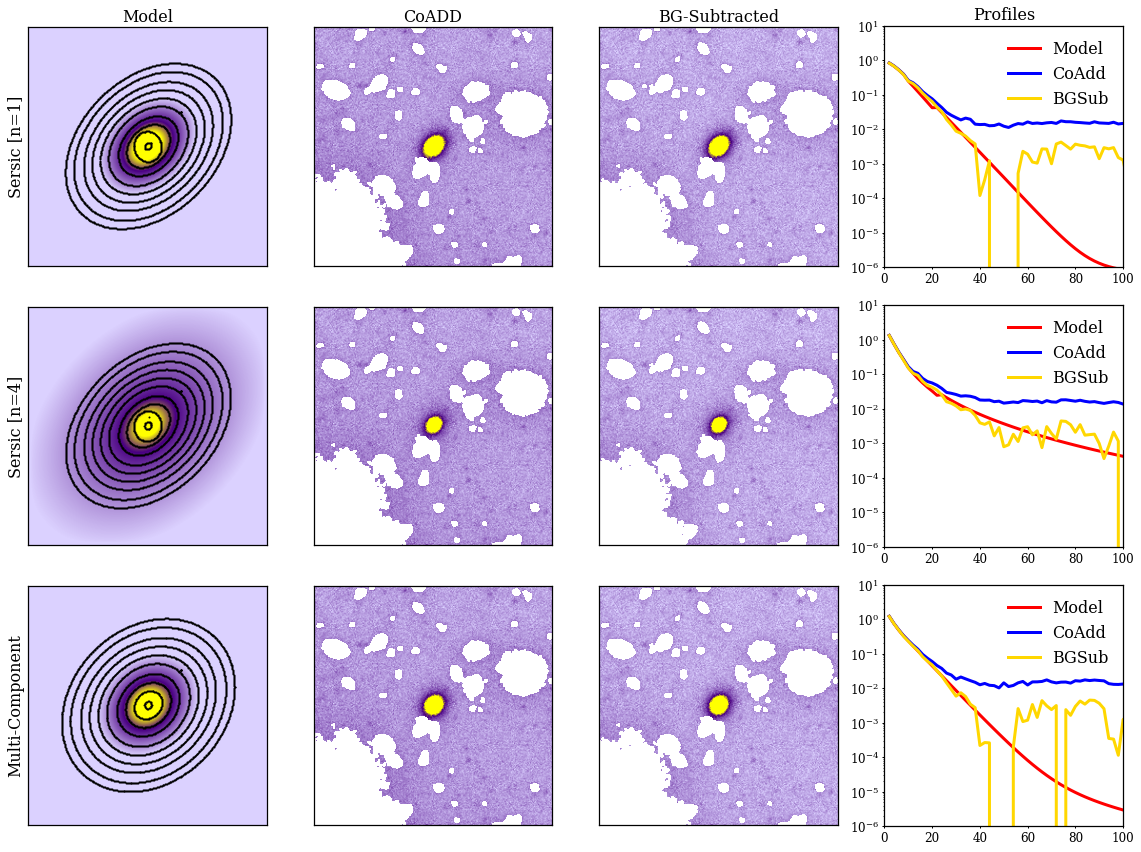

In [27]:
fig, ax = plt.subplots(3, 4, figsize=(16, 12))

ylabels = ["Sersic [n=1]", "Sersic [n=4]", "Multi-Component"]
xlabels = ["Model", "CoADD", "BG-Subtracted", "Profiles"]

for i in range(len(xlabels)):
    ax[0][i].set_title(xlabels[i], fontsize=16)
for i in range(len(ylabels)):    
    ax[i][0].set_ylabel(ylabels[i], fontsize=16)

models = [output_n1, output_n4, output_bd]

lw=3

for i, row in enumerate(ax):
    mod, bgadded_masked, bgsub, mod_prof, bgadded_prof, bgsub_prof = models[i]
    
    mod_tab, bgadded_tab, bgsub_tab = mod_prof.to_table(), bgadded_prof.to_table(), bgsub_prof.to_table()

    row[0].imshow(np.log10(mod), cmap=cmap, origin="lower", vmin=-4, vmax=-1)
    
    row[1].imshow(bgadded_masked, cmap=cmap, origin="lower", vmin=vmin, vmax=vmax)

    row[2].imshow(bgsub, cmap=cmap, origin="lower", vmin=vmin, vmax=vmax)

    row[3].plot(mod_tab["sma"], mod_tab["intens"], 
                label="Model", color="red", lw=lw)
    row[3].plot(bgadded_tab["sma"], bgadded_tab["intens"],
                label="CoAdd", color="blue", lw=lw)
    row[3].plot(bgsub_tab["sma"], bgsub_tab["intens"],
                label="BGSub", color="gold", lw=lw)
    row[3].set(yscale="log", ylim=[1e-6, 1e1], xlim=[0, 100])
    row[3].legend(loc="upper right", fontsize=16, frameon=False)

    overplot_isophotes(row[0], mod_prof, rs=np.linspace(5, 100, 10), color="black")
    # overplot_isophotes(row[1], bgadded_prof, rs=np.arange(0, 50, 5), color="black")
    # overplot_isophotes(row[2], bgsub_prof, rs=np.arange(0, 50, 5), color="black")

for row in ax:
    for ax_ in row[:3]:
        ax_.set(xticks=[], yticks=[])


plt.tight_layout()
plt.savefig("plots/gprime_sim.pdf", dpi=200)